In [1]:
from pyspark import SparkConf, SparkContext
import json

conf = SparkConf().setAppName("RDD-5000-Sample")
sc = SparkContext(conf=conf)


rdd = sc.textFile("/Users/paul/Downloads/Kindle_Store.jsonl")

parsed_rdd = rdd.map(lambda line: json.loads(line))

sample_rdd = parsed_rdd.takeSample(False, 5000, seed=42)

sample_rdd = sc.parallelize(sample_rdd)

print(sample_rdd.take(5))


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/02 21:29:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/opt/anaconda3/envs/DistributedComputing/lib/python3.12/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py:154: DeprecationWarning: This process (pid=20062) is multi-threaded, use of fork() may lead to deadlocks in the child.
25/12/02 21:29:37 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


[{'rating': 3.0, 'title': 'Just ok', 'text': 'This book was good in the begging but dragged after that.', 'images': [], 'asin': 'B073HBFHLN', 'parent_asin': 'B073HBFHLN', 'user_id': 'AHZZTGWG65W6RBEHIVWSYKDEWQRQ', 'timestamp': 1507402441573, 'helpful_vote': 0, 'verified_purchase': True}, {'rating': 4.0, 'title': '3.5 stars', 'text': "Enjoyable read. Good chemistry between the characters.  Likable h/H.<br /><br />If it's a billionaire then I will more than likely read.  It's one of my favorite tropes.  The confident billionaire who is able to woo the panties off.<br /><br />Good start to a series.", 'images': [], 'asin': 'B01ERT16PW', 'parent_asin': 'B01ERT16PW', 'user_id': 'AF4SYJEHFYCMD3RFNBOZ2TR4UETA', 'timestamp': 1473206473000, 'helpful_vote': 0, 'verified_purchase': True}, {'rating': 5.0, 'title': 'This book is a SOLID!!!', 'text': "I decided to read Dungeon Crawler Carl (book 1) as a break from some seriously heavy reading, and as it progressed, I was quite entertained. Now, this

The question I was interested in is what constitutes a good book rating? Subquestions include do good book ratings correspond to very specific key features? What types of reviews to users find most helpful?


In [2]:
sample_rdd = sample_rdd.map(
    lambda x: (
        str(x.get('asin', '')),                        
        str(x.get('parent_asin', '')),                 
        str(x.get('title', '')),                      
        str(x.get('text', '')),                        
        float(x.get('rating', 0.0)),                   
        int(x.get('timestamp', 0)),                    
        str(x.get('user_id', '')),                     
        bool(x.get('verified_purchase', False)),       
        int(x.get('helpful_vote', 0)),                
        int(len(x.get('images', [])))                
)
)


In [3]:
sample_rdd.take(1)

[('B073HBFHLN',
  'B073HBFHLN',
  'Just ok',
  'This book was good in the begging but dragged after that.',
  3.0,
  1507402441573,
  'AHZZTGWG65W6RBEHIVWSYKDEWQRQ',
  True,
  0,
  0)]

In [4]:
valid_reviews = sample_rdd.filter(lambda x: x[7] == True) #I kind of only want verified reviews of people confirmed to order the specific book


In [5]:
ratings = valid_reviews.map(lambda x: x[4])

count = ratings.count()
mean = ratings.mean()
stdev = ratings.stdev()
min_val = ratings.min()
max_val = ratings.max()

(count, mean, stdev, min_val, max_val) 


(3349, 4.4252015527022985, 0.986700602873504, 1.0, 5.0)

The standard deviation is around 1, with a relatively high mean of 4.4252. That is, most of the reviews on the site seem to be positive.

In [6]:
pair_rdd = valid_reviews.map(lambda x: (x[8], (x[4], 1)))
reduced = pair_rdd.reduceByKey(
    lambda x, y: (x[0] + y[0], x[1] + y[1])
)
avg_ratings = reduced.mapValues(lambda x: (x[0] / x[1], x[1]))
result = avg_ratings.sortByKey()
for row in result.take(40):
    print(row)
#This shows the (# helpful votes, (avg rating, # of reviews in this class))

(0, (4.50989898989899, 2475))
(1, (4.341650671785029, 521))
(2, (4.1911764705882355, 136))
(3, (4.0, 70))
(4, (3.5714285714285716, 42))
(5, (3.625, 16))
(6, (3.5294117647058822, 17))
(7, (4.0, 11))
(8, (4.0, 4))
(9, (5.0, 5))
(10, (3.875, 8))
(11, (4.5, 2))
(12, (3.8333333333333335, 6))
(13, (3.6666666666666665, 3))
(14, (3.3333333333333335, 3))
(15, (2.0, 1))
(17, (5.0, 1))
(18, (3.75, 4))
(19, (4.333333333333333, 3))
(20, (2.25, 4))
(21, (5.0, 2))
(22, (1.0, 1))
(23, (5.0, 1))
(24, (1.0, 1))
(27, (4.5, 2))
(28, (3.5, 2))
(31, (5.0, 1))
(32, (4.5, 2))
(39, (3.0, 1))
(47, (4.0, 1))
(52, (5.0, 1))
(109, (3.0, 1))
(520, (3.0, 1))


We see that the distribution based on average helpful ratings per number of help review votes seems to be very randomly distributed which it would be useful to do further testing on to gauge any larger trends. 

Next, I will find the distribution of ratings

In [7]:
good = valid_reviews.map(lambda x: (1 if x[4] >= 4 else 0, 1))
counts = good.reduceByKey(lambda x, y: x + y)
counts.collect()

#This just shows that there are 2877 views classified by our metric as "good" and 678 not.

[(0, 472), (1, 2877)]

In [8]:
bad = sample_rdd.map(lambda x: (1 if x[4] < 3 else 0, 1))
counts = bad.reduceByKey(lambda x, y: x + y)
counts.collect() 
#This shows that we have 296 reviews that are considered "bad" by our metric, so their is an extreme imbalance. 
#If we do sentiment scoring, this may be something to consider

[(0, 4704), (1, 296)]

Does length play a role in review helpfulness?

In [9]:
length= valid_reviews.map(lambda x: (x[4], len(x[3])))  
comb = valid_reviews.map(lambda x: (len(x[3]), 1))
sum, count = comb.reduce(lambda x, y: (x[0] + y[0], x[1] + y[1]))
avg = sum / count
print(avg)

pair_rdd = valid_reviews.map(lambda x: (x[4], (len(x[3]), 1)))

reduced = pair_rdd.reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))

avgLen = reduced.mapValues(lambda x: x[0] / x[1])

for row in avgLen.sortByKey().collect():
    print(row)


267.9235592714243


(1.0, 291.5765765765766)
(2.0, 492.41237113402065)
(3.0, 305.31439393939394)
(4.0, 285.26888217522657)
(5.0, 247.2668171557562)


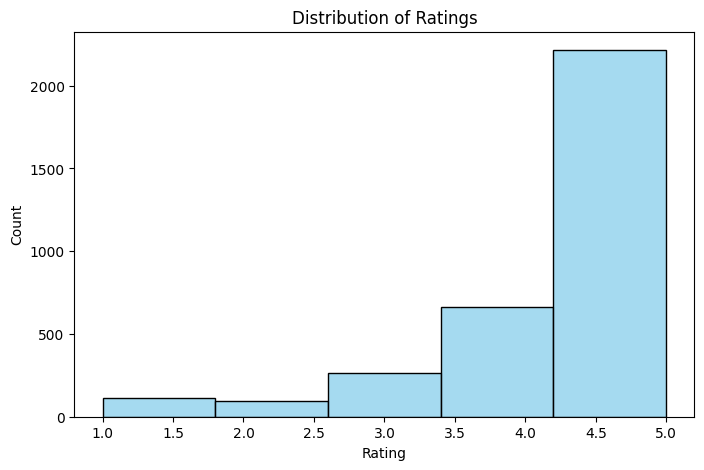

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
ratings_list = ratings.collect()  

plt.figure(figsize=(8, 5))
sns.histplot(ratings_list, bins=5, color='skyblue')
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

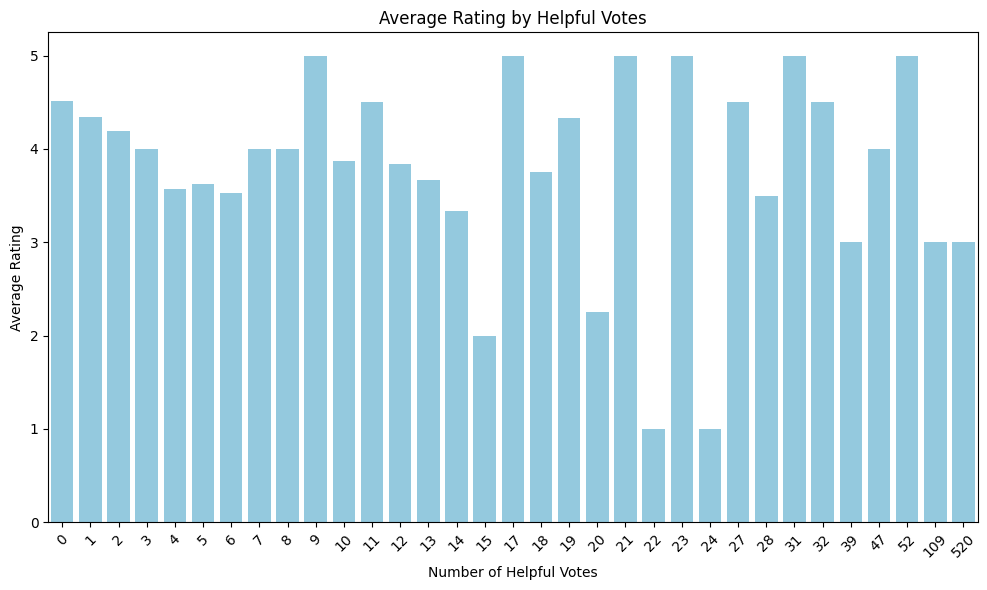

In [18]:
helpful_rating_list = avg_ratings.collect() 


helpful_votes = [x[0] for x in helpful_rating_list]
avg_ratings_vals = [x[1][0] for x in helpful_rating_list]

sorted_idx = sorted(range(len(helpful_votes)), key=lambda i: helpful_votes[i])
hv_sorted = [helpful_votes[i] for i in sorted_idx]
avg_sorted = [avg_ratings_vals[i] for i in sorted_idx]

plt.figure(figsize=(10, 6))
sns.barplot(x=hv_sorted, y=avg_sorted, color='skyblue')
plt.xlabel("Number of Helpful Votes")
plt.ylabel("Average Rating")
plt.title("Average Rating by Helpful Votes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/var/folders/hd/9y8cvc3x51n5ckskc6mypk840000gn/T/ipykernel_20033/4003281867.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


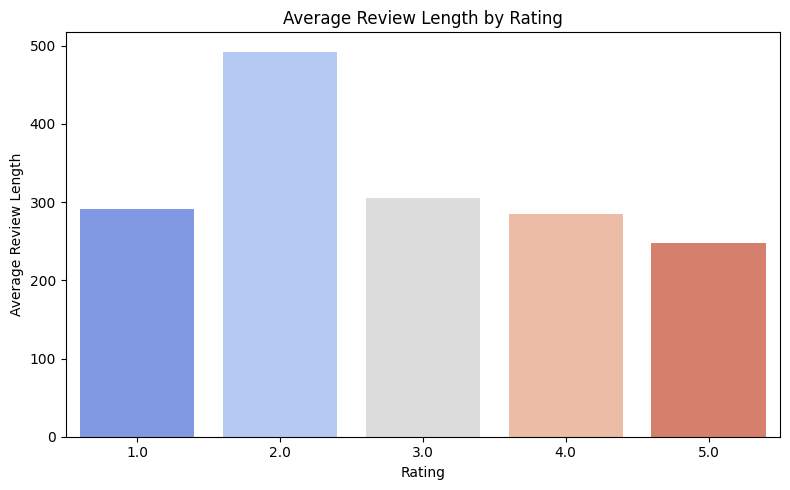

In [ ]:
avgLen_list = avgLen.sortByKey().collect()  

plt.figure(figsize=(8, 5))
sns.barplot(
    x=[x[0] for x in avgLen_list], 
    y=[x[1] for x in avgLen_list],  
    palette="coolwarm"
)
plt.xlabel("Rating")
plt.ylabel("Average Review Length")
plt.title("Average Review Length by Rating")
plt.tight_layout()
plt.show()

We see that by a significant margin, ratings of 2.0 recieve longer review lengths , while other review lengths are relatively similar in the 250-400 character length.